In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
import torchvision
import cv2

from tqdm.notebook import tqdm, trange

from torch import nn

In [2]:
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)


In [3]:
dir = {}
dir['tr_img'] = 'tests/00_test_val_input/train/images'
dir['tr_gt'] = 'tests/00_test_val_input/train/gt'
dir['te_img'] = 'tests/00_test_val_input/test/images'
dir['te_gt'] = 'tests/00_test_val_gt'


for k, v in dir.items():
    assert len(os.listdir(v)) == 200

In [4]:
next(iter(zip(os.listdir(dir['tr_img']), os.listdir(dir['tr_gt']))))

('001.Black_footed_Albatross', '001.Black_footed_Albatross')

In [5]:
def load_img(path):
    img = torchvision.io.read_image(path)
    return img

def show_imgs(imgs, transform=None):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.to('cpu')
        if transform:
            img = transform(img)
            
        img = torchvision.transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(128),
    torchvision.transforms.CenterCrop(128),
    lambda x: x.float() / 255
])
inv_transform = torchvision.transforms.Compose([
    lambda x: x
])

to3channel = lambda x: torch.vstack((x, x, x)) if x.shape == torch.Size([1, 128, 128]) else x
to1channel = lambda x: x.mean(dim=0).reshape(-1, 128, 128) if x.shape == torch.Size([2, 128, 128]) else x

assert to3channel(torch.zeros((1, 128, 128))).shape == torch.Size([3, 128, 128])
assert to1channel(torch.zeros((2, 128, 128))).shape == torch.Size([1, 128, 128])

In [6]:
# filename = dir['tr_img'] + '/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg'
# imgs = []
# imgs.append(load_img(filename))
# imgs.append(transform(load_img(filename)))

# show_imgs(imgs)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, gt_dir, *, load_only_names=False, one_class=False):
        self.load_only_names = load_only_names
        
        items_names = []

        for imgd, gtd in zip(os.listdir(img_dir), os.listdir(gt_dir)):
            assert imgd == gtd
            imgd = os.path.join(img_dir, imgd)
            gtd = os.path.join(gt_dir, gtd)
        
            for img_name, gt_name in zip(os.listdir(imgd), os.listdir(gtd)):
                assert img_name[:-3] == gt_name[:-3]
                img_name = os.path.join(imgd, img_name)
                gt_name = os.path.join(gtd, gt_name)
                
                items_names.append((img_name, gt_name))
            
            if one_class:
                break
        
        if self.load_only_names:
            self.items = items_names
            return
        
        self.items = []

        for img_name, gt_name in tqdm(items_names):
            img = torchvision.io.read_image(img_name)
            gt = torchvision.io.read_image(gt_name)
            
            self.items.append((img_name, gt_name, to3channel(transform(img)), to1channel(transform(gt))))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        if self.load_only_names:
            img_name, gt_name = self.items[i]
            
            img = torchvision.io.read_image(img_name)
            gt = torchvision.io.read_image(gt_name)
            
            return img_name, gt_name, to3channel(transform(img)), to1channel(transform(gt))

        return self.items[i]

In [8]:
# train_dataset = MyDataset(dir['tr_img'], dir['tr_gt'])
# test_dataset = MyDataset(dir['te_img'], dir['te_gt'])

train_dataset = MyDataset(dir['tr_img'], dir['tr_gt'], load_only_names=True)
test_dataset = MyDataset(dir['te_img'], dir['te_gt'], load_only_names=True)

In [9]:
def test_shapes():
    for _, _, img, gt in train_dataset:
        if img.shape[0] == 1:
            continue
        if gt.shape[0] == 2:
            print(2, end=' ')
            continue
        assert img.shape == torch.Size([3, 128, 128]), img.shape
        assert gt.shape == torch.Size([1, 128, 128]), gt.shape

# test_shapes()

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=True)

In [11]:
next(iter(train_dataloader))[2].shape, next(iter(train_dataloader))[3].shape

/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order 

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

In [12]:
h = 16

x = next(iter(train_dataloader))[2]
print(x.shape)

x = nn.Sequential(nn.Conv2d(3, h, 3, padding=1), nn.MaxPool2d(2))(x)
print(x.shape)

x = nn.Sequential(nn.Conv2d(h, h, 3, padding=1), nn.MaxPool2d(2))(x)
print(x.shape)

x = nn.Sequential(nn.Conv2d(h, h, 3, padding=1), nn.MaxPool2d(2))(x)
print(x.shape)

x = nn.Sequential(nn.Conv2d(h, h, 3, padding=1), nn.MaxPool2d(2))(x)
print(x.shape)

print()

x = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(h, h, 3, padding=1))(x)
print(x.shape)

x = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(h, h, 3, padding=1))(x)
print(x.shape)

x = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(h, h, 3, padding=1))(x)
print(x.shape)

x = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), nn.Conv2d(h, 1, 3, padding=1))(x)
print(x.shape)

/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order 

torch.Size([16, 3, 128, 128])
torch.Size([16, 16, 64, 64])
torch.Size([16, 16, 32, 32])
torch.Size([16, 16, 16, 16])
torch.Size([16, 16, 8, 8])

torch.Size([16, 16, 16, 16])
torch.Size([16, 16, 32, 32])
torch.Size([16, 16, 64, 64])
torch.Size([16, 1, 128, 128])


In [13]:
class convrelu(nn.Module):
    def __init__(self, i, o, k, p):
        super().__init__()

        self.layers = nn.Sequential(nn.Conv2d(i, o, k, padding=p), nn.ReLU())

    def forward(self, x):
        return self.layers(x)
        
class Autoencoder(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        
        self.cr1 = convrelu(3, h, 3, 1)
        self.cr2 = convrelu(h, h, 3, 1)
        self.cr3 = convrelu(h, 2*h, 3, 1)
        self.cr4 = convrelu(2*h, 4*h, 3, 1)
        self.cr5 = convrelu(4*h, 8*h, 3, 1)
        self.cr6 = convrelu(4*h + 8*h, 4 * h, 3, 1)
        self.cr7 = convrelu(2*h + 4*h, 2 * h, 3, 1)
        self.cr8 = convrelu(h + 2*h, h, 3, 1)
        self.cr9 = convrelu(h+h, h, 3, 1)

        self.conv1x1 = nn.Conv2d(h, 1, 1, padding=0)
        self.act = nn.Sigmoid()
        
        self.mp1 = nn.MaxPool2d(2)
        self.mp2 = nn.MaxPool2d(2)
        self.mp3 = nn.MaxPool2d(2)
        self.mp4 = nn.MaxPool2d(2)
        self.us5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.us6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.us7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.us8 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        
    def forward(self, x):
        x1 = self.cr1(x)            # b h 128 128
        x2 = self.cr2(self.mp1(x1)) # b h 64 64
        x3 = self.cr3(self.mp2(x2)) # b 2h 32 32
        x4 = self.cr4(self.mp3(x3)) # b 4h 16 16
        x5 = self.cr5(self.mp4(x4)) # b 8h 8 8

        x6 = torch.cat((x4, self.us5(x5)), dim=1) # b 4h+8h 16 16
        x6 = self.cr6(x6)                         # b 4h 16 16
        
        x7 = torch.cat((x3, self.us6(x6)), dim=1) # b 2h+4h 32 32
        x7 = self.cr7(x7)                         # b 2h 32 32
        
        x8 = torch.cat((x2, self.us7(x7)), dim=1) # b h+2h 64 64
        x8 = self.cr8(x8)                         # b h 64 64
        
        x9 = torch.cat((x1, self.us8(x8)), dim=1) # b h+h 128 128
        x9 = self.cr9(x9)                         # b h 128 128

        x10 = self.act(self.conv1x1(x9))

        return x10

In [14]:
model = Autoencoder()
x = next(iter(train_dataloader))[2]
x = model(x).detach()
x.shape, x.min(), x.max(), x.dtype

/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order 

(torch.Size([16, 1, 128, 128]), tensor(0.4724), tensor(0.5061), torch.float32)

In [15]:
def train(epoch, model, optim, losses, val_losses, *, epochs=10):
    # loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    loss_fn = nn.MSELoss()
    # loss_fn = nn.BCEWithLogitsLoss()

    loss = None
    with trange(epochs, leave=True, desc='') as pbar:
        for e in pbar:
            for _, _, img, gt in tqdm(train_dataloader, leave=False):
        
                optim.zero_grad()
                        
                out = model(img.to(device))
                loss = loss_fn(out, gt.to(device))
        
                loss.backward()
                optim.step()

                loss = loss.detach().cpu()
                losses.append(loss.item())
                
                pbar.set_description(f'loss: {np.mean(losses[:-10]):.4e}')
                
            with torch.no_grad():
                for _, _, img, gt in tqdm(test_dataloader, leave=False):
                    x = model(img.to(device))
                    loss = loss_fn(x, gt.to(device))
                    val_losses.append(loss.detach().cpu().mean())

            epoch += 1
            save_checkpoint(epoch, model, optim, losses, val_losses, path=generate_checkpoint_path())

In [16]:
def new_checkpoint():
    epoch = 0
    model = Autoencoder()
    optim = torch.optim.Adam(model.parameters(), lr=0.001 * 0.5)
    losses = []
    val_losses = []
    
    return epoch, model, optim, losses, val_losses

def save_checkpoint(epoch, model, optim, losses, val_losses, *, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optim_state_dict': optim.state_dict(),
            'losses': losses,
            'val_losses': val_losses,            
        }, 
        path
    )

def load_checkpoint(path):
    epoch, model, _, losses, val_losses = new_checkpoint()
    
    checkpoint = torch.load(path)

    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    optim.load_state_dict(checkpoint['optim_state_dict'])
    
    losses = checkpoint['losses']
    val_losses = checkpoint['val_losses']

    return epoch, model, optim, losses, val_losses

def generate_checkpoint_path(dir_path='checkpoints'):
    'checkpoint_{:03}.ckpt'
    
    ld = os.listdir(dir_path)
    i = max(int(name[11:14]) for name in ld) if ld else -1
    return os.path.join(dir_path, 'checkpoint_{:03}.ckpt'.format(i + 1))

In [17]:
device = torch.device('cuda')
device

device(type='cuda')

In [18]:
epoch, model, optim, losses, val_losses = new_checkpoint()

In [19]:
train(epoch, model, optim, losses, val_losses, epochs=4)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order 

KeyboardInterrupt: 

In [ ]:
epoch, model, optim, losses, val_losses = load_checkpoint('checkpoints/checkpoint_006.ckpt')
epoch

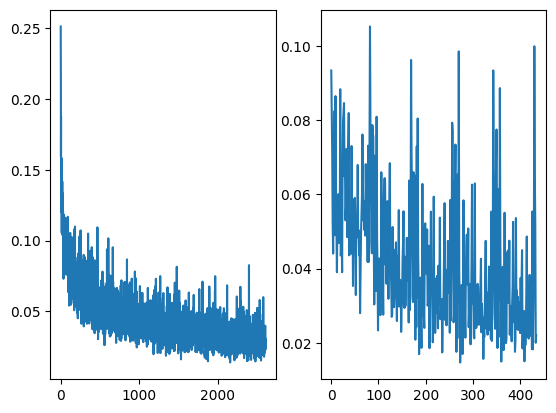

In [21]:
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(val_losses)
plt.show()

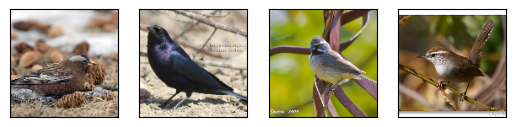

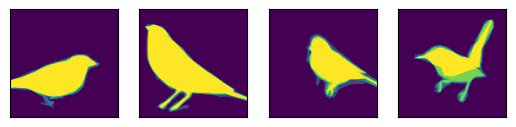

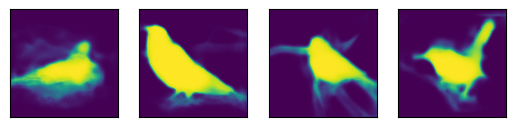

In [22]:
_, _, imgs, gts = next(iter(train_dataloader))
model.to(device)
outs = model(imgs.to(device)).detach().cpu()

show_imgs(imgs[:4], transform=inv_transform)
show_imgs(gts[:4])
show_imgs(outs[:4])

In [23]:
def compute_iou(a, b):
    a = a.clip(0, 1)
    b = b.clip(0, 1)
    return float((a * b).sum() / torch.max(a, b).sum())

def compute_iou(a, b):
    a = a > .5
    b = b > .5
    return (a & b).sum() / (a | b).sum()

In [24]:
print(' '.join('{:.2f}'.format(compute_iou(a, b)) for a, b in zip(gts, outs)))

0.62 0.90 0.79 0.81 0.69 0.92 0.81 0.90 0.70 0.75 0.79 0.90 0.20 0.79 0.64 0.67


In [25]:
(gts[0] > .5).dtype

torch.bool

In [26]:
(torch.Tensor([0, .7, .6]) > .5).sum()

tensor(2)

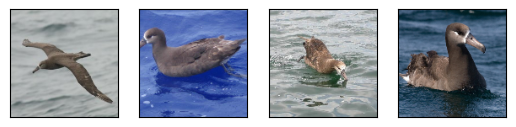

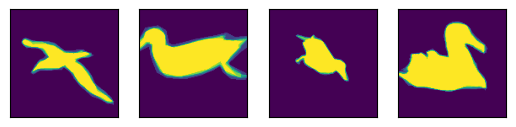

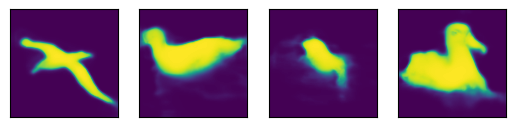

In [27]:
_, _, imgs, gts = next(iter(test_dataloader))
outs = model(imgs.to(device)).detach().cpu()

show_imgs(imgs[:4], transform=inv_transform)
show_imgs(gts[:4])
show_imgs(outs[:4])

In [28]:
print(' '.join('{:.2f}'.format(compute_iou(a, b)) for a, b in zip(gts, outs)))

0.90 0.84 0.79 0.92 0.75 0.84 0.93 0.65 0.48 0.60 0.61 0.72 0.54 0.85 0.69 0.67


In [ ]:
ious = []
with torch.no_grad():
    for _, _, img, gt in tqdm(test_dataloader, leave=False):
        out = model(img.to(device)).cpu()
        ious += [compute_iou(a, b) for a, b in zip(gt, out)]

np.mean(ious)

  0%|          | 0/87 [00:00<?, ?it/s]